# RDPA coordinates for the reference equilibrium

To reduce the sensitivity of the RDPA to movement of the magnetic
equilibrium, we use the $R^u - R_{sep}^u$ flux coordinate along with the
vertical coordinate to combine the RDPA measurements.

To compare to the simulations, we need to find what $R, Z$ points the
RDPA $R^u - R_{sep}^u, Z$ points correspond to.

Since the flux surfaces are curved, there are potentially several valid
points which have the correct $R^u - R_{sep}^u, Z$. We want to limit
our selection to points which are near the RDPA measurement area. This
is done once manually.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tcvx21.units_m import Quantity, Dimensionless, convert_xarray_to_quantity
import tcvx21
from scipy.interpolate import griddata
from pathlib import Path

plt.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['figure.facecolor'] = 'white'
xr.set_options(keep_attrs=True)

First of all, let's load in the RDPA coordinates. Although we have 2D data,
due to the flux surface mapping, the points are not orthogonal, so let's treat
this as tricolumn data.

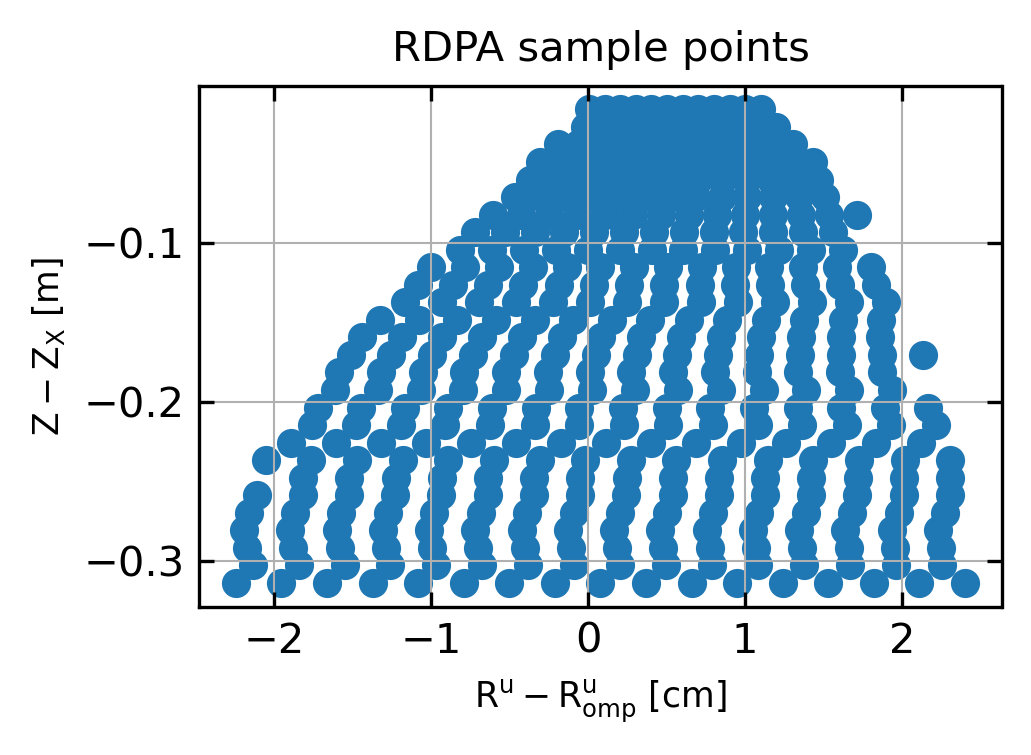

In [2]:
rdpa = tcvx21.file_io.read_struct_from_file(Path('../dataset_TCVX21.mat'), struct_name='dataset')['Forw']['RDPA']

def rdpa_coordinates(rdpa, plot: bool=False):
    """
    Returns the (R_sep, Z) coordinate arrays from the RDPA
    """
    rsep_coord = np.array([])
    zx_coord = np.array([])

    for z, rsep in zip(rdpa['Zx'], rdpa['Ru']):

        rsep_coord = np.append(rsep_coord, rsep)
        zx_coord = np.append(zx_coord, z * np.ones_like(rsep))

    rsep_coord = Quantity(rsep_coord, rdpa['Ru_units']).to('cm')
    zx_coord = Quantity(zx_coord, rdpa['Zx_units'])

    if plot:
        _, ax = plt.subplots()
        ax.scatter(rsep_coord, zx_coord)
        ax.set_xlabel('$R^u - R^u_{omp}$ '+f"[{rsep_coord.units}]")
        ax.set_ylabel('$Z - Z_X$ '+f"[{zx_coord.units}]")
        ax.set_title('RDPA sample points')

    return rsep_coord, zx_coord

rdpa_rsep, rdpa_zx = rdpa_coordinates(rdpa['observables']['density'], plot=True)

Next, let's see if we can map this onto our simulation grid. First of all,
we set up a small case (the processing example).

In [3]:
import tcvx21.grillix_post as grillix

file_path = tcvx21.test_dir / 'sample_data'

norm = grillix.components.Normalisation.initialise_from_normalisation_file(file_path/'physical_parameters.nml')
equi = grillix.components.Equi(file_path/'TCV_ortho.nc',
                file_path/'pen_metainfo.nc',
                flip_z=False)

omp_map = grillix.lineouts.OutboardMidplaneMap(grillix.components.Grid(file_path / 'vgrid.nc'), equi, norm)

Next, we calculate $R, Z, R^u - R^u_{sep}$ for each grid point.
Then, we can use `griddata` to interpolate `R(R^u - R^u_{sep}, Z)` onto the
points defined by the RDPA.

Couldn't find a point in the reference equilibrium for 9 points
Max deviation of R^u: 0.656 millimeter


<ipython-input-4-67f23acec278>:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_xticks()*norm.R0])
<ipython-input-4-67f23acec278>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_yticks()*norm.R0])


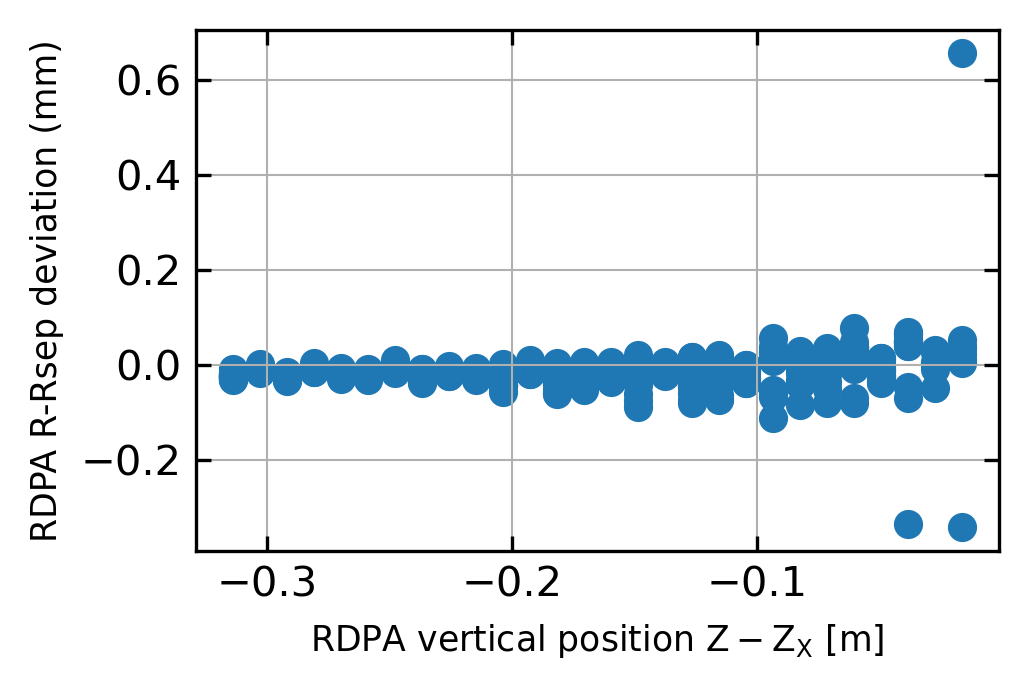

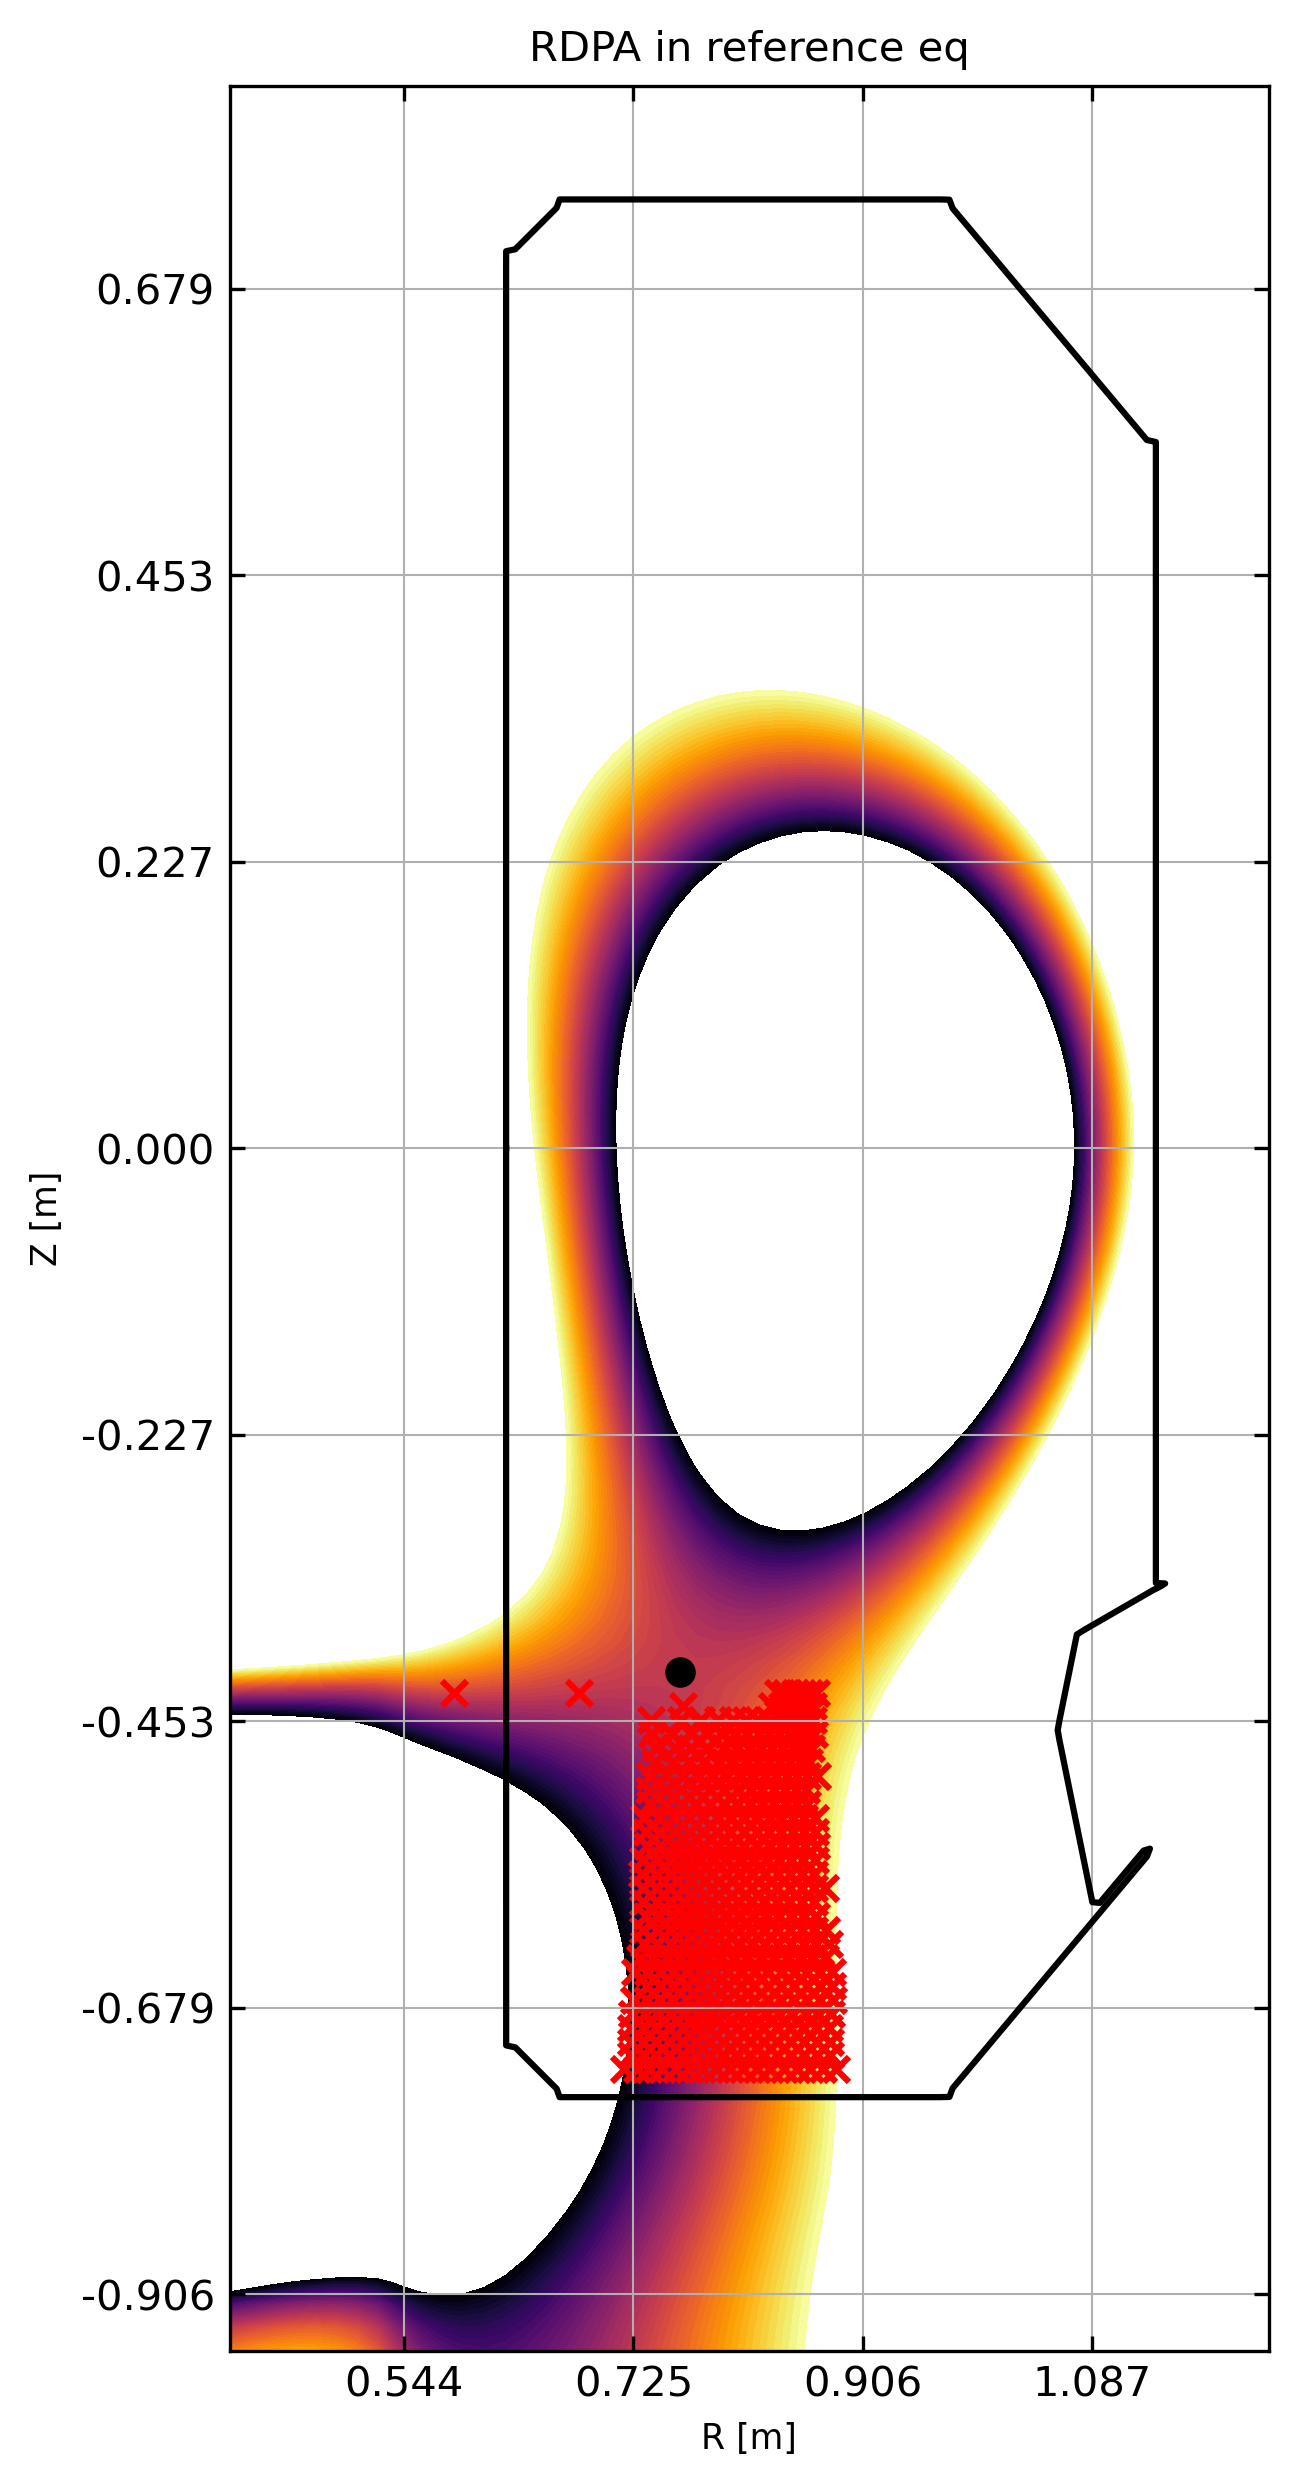

In [4]:
def rdpa_rsep_to_r(rdpa_rsep, rdpa_zx, equi, norm, limits={}, method: str='linear', plot: bool=False,
                   r_samples=50, z_samples=100, precision_required = Quantity(1, 'mm')):
    """
    Returns the R values corresponding to (R_sep, Z) values from the RDPA
    """

    x_point_z = convert_xarray_to_quantity(equi.x_point_z)
    rdpa_z = rdpa_zx + x_point_z

    rdpa_rho = omp_map.convert_distance_to_rho(rdpa_rsep)
    rdpa_rsep = (rdpa_rsep / norm.R0).to('').magnitude
    rdpa_z = (rdpa_z / norm.R0).to('').magnitude

    spline_r = equi.spline_basis_r.values
    spline_z = equi.spline_basis_z.values

    rmin = limits.get('rmin', spline_r.min())
    rmax = limits.get('rmax', spline_r.max())

    zmin = spline_z.min()
    zmax = spline_z.max()
    if 'zmin' in limits.keys():
        if equi.flipped_z:
            zmax = -limits['zmin']
        else:
            zmin = limits['zmin']
    if 'zmax' in limits.keys():
        if equi.flipped_z:
            zmin = -limits['zmax']
        else:
            zmax = limits['zmax']

    r_tests = np.linspace(rmin, rmax, num=r_samples)
    z_tests = np.linspace(zmin, zmax, num=z_samples)
    rho = equi.normalised_flux_surface_label(r_tests, z_tests)
    if equi.flipped_z:
        z_tests *= -1

    r_mesh, z_mesh = np.meshgrid(r_tests, z_tests)
    equi_rsep = omp_map.convert_rho_to_distance(rho)

    rdpa_r = griddata(points=(equi_rsep.values.ravel(), z_mesh.ravel()),
                      values=r_mesh.ravel(),
                      xi=(rdpa_rsep, rdpa_z),
                      method=method, rescale=True)

    rdpa_rsep_tests = omp_map.convert_rho_to_distance(
        equi.normalised_flux_surface_label(rdpa_r, rdpa_z * (-1.0 if equi.flipped_z else 1.0), grid=False)
    )

    rdpa_r[np.abs(rdpa_rsep_tests - rdpa_rsep)*norm.R0 > precision_required] = np.nan
    rdpa_rsep_tests = omp_map.convert_rho_to_distance(
        equi.normalised_flux_surface_label(rdpa_r, rdpa_z * (-1.0 if equi.flipped_z else 1.0), grid=False)
    )
    if np.any(np.isnan(rdpa_r)):
        print(f"Couldn't find a point in the reference equilibrium for {np.count_nonzero(np.isnan(rdpa_r))} points")

    if plot:
        _, ax = plt.subplots()
        plt.scatter(rdpa_zx.to('m'), (rdpa_rsep_tests - rdpa_rsep)*norm.R0.to('mm'))
        plt.xlabel('RDPA vertical position $Z - Z_X$ [m]')
        plt.ylabel('RDPA R-Rsep deviation (mm)')
        print(f"Max deviation of R^u: {convert_xarray_to_quantity(np.max(np.abs(rdpa_rsep - rdpa_rsep_tests))).to('mm'):4.3}")

    if plot:
        _, ax = plt.subplots(figsize=(10,10))
        ax.contourf(r_mesh, z_mesh, rho.values, levels=np.linspace(rdpa_rho.min(), rdpa_rho.max()))
        ax.scatter(rdpa_r, rdpa_z, marker='x', color='r')
        ax.scatter(equi.x_point_r_norm, equi.x_point_z_norm, marker='o', color='k', s=40)
        ax.set_xlim(limits.get('rmin', None), limits.get('rmax', None))
        ax.set_ylim(limits.get('zmin', None), limits.get('zmax', None))
        ax.set_aspect('equal')
        ax.set_xlabel('R [m]')
        ax.set_ylabel('Z [m]')
        ax.set_title('RDPA in reference eq')
        divertor_ = tcvx21.read_from_json(Path('divertor_polygon.json'))
        plt.plot(divertor_['r_points']/equi.axis_r.values,
                 divertor_['z_points']/equi.axis_r.values,
                 color='k')

        ax.set_xticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_xticks()*norm.R0])
        ax.set_yticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_yticks()*norm.R0])


    return rdpa_r * norm.R0

rdpa_r = rdpa_rsep_to_r(rdpa_rsep, rdpa_zx, equi, norm,
                        plot=True)

Looks like it almost worked. But as we approach the X-point, the points jump to
the flux-surface on the high-field side, and some selected points
are outside the vessel.

We can prevent this by passing limits, to tell the routine where to look
for coordinate points.

Max deviation of R^u: 0.0176 millimeter


<ipython-input-4-67f23acec278>:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_xticks()*norm.R0])
<ipython-input-4-67f23acec278>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_yticks()*norm.R0])


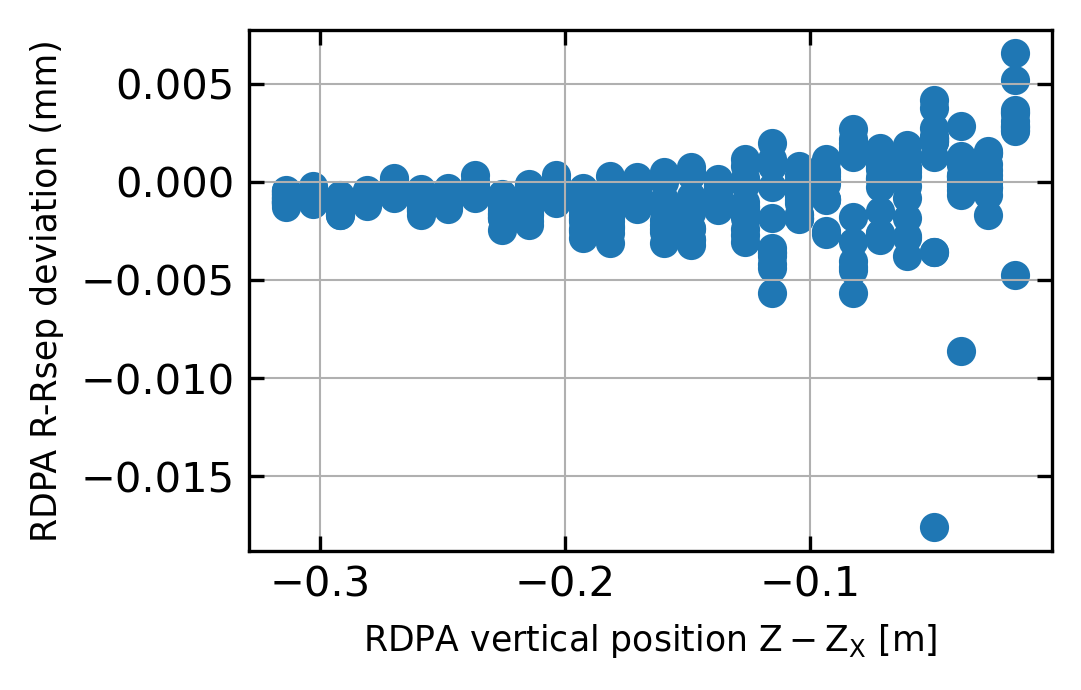

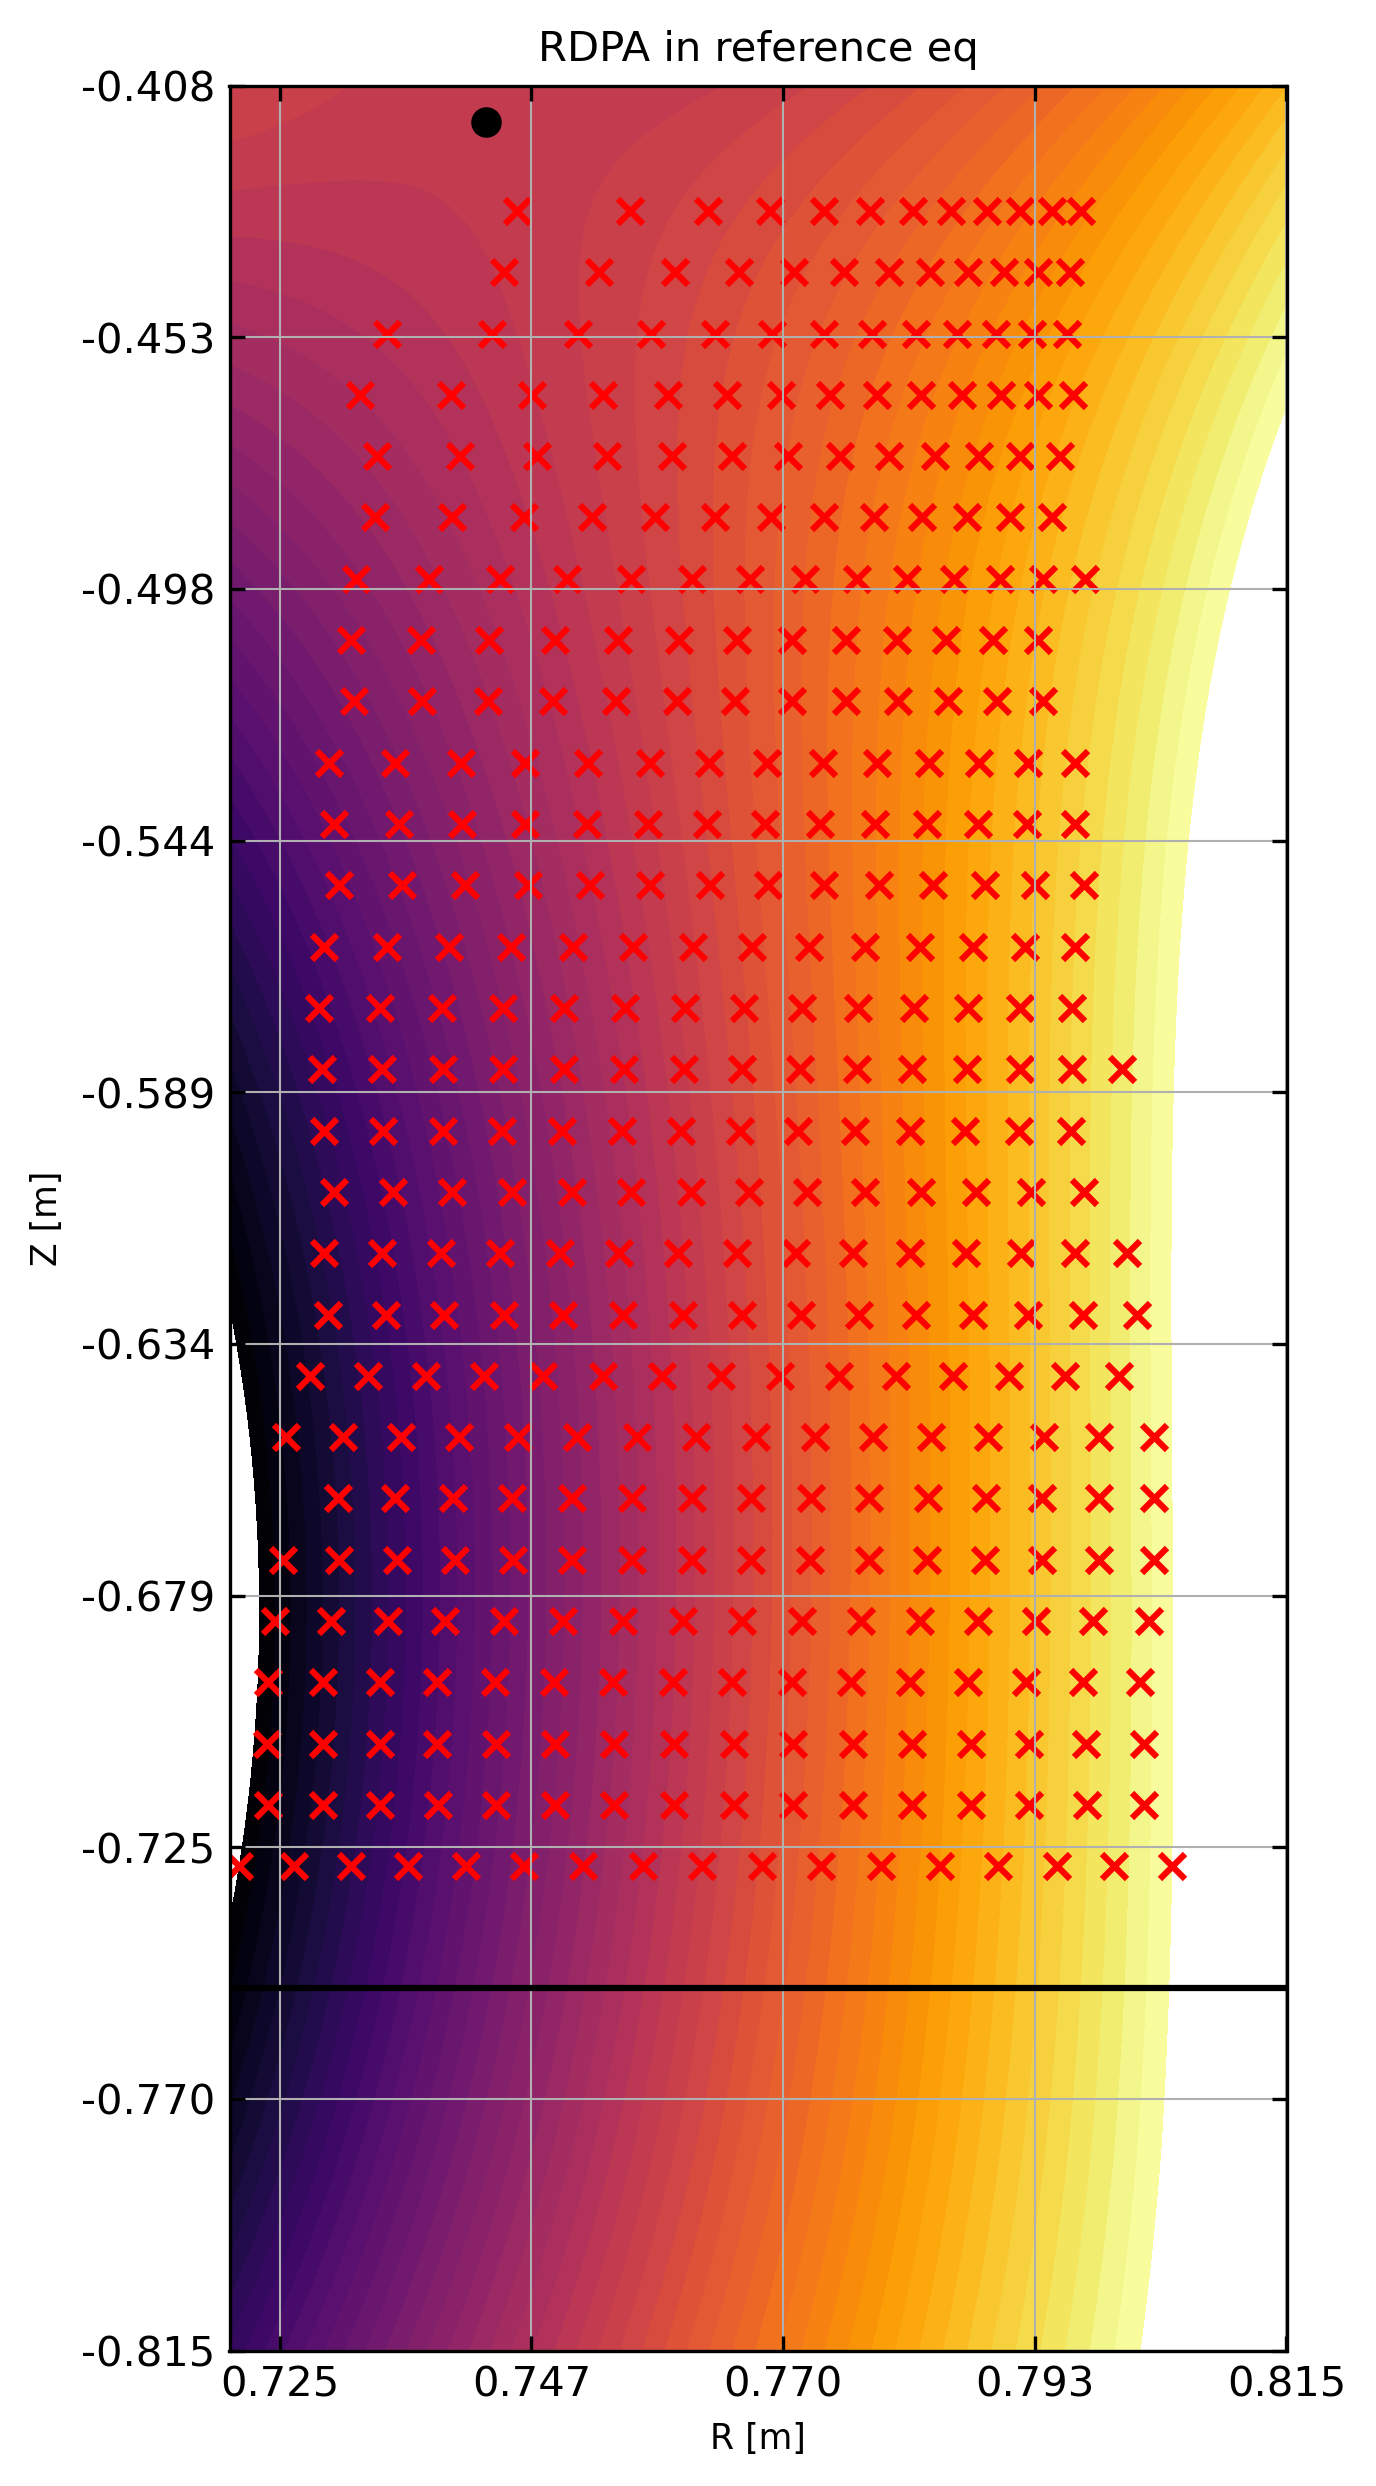

In [5]:
rdpa_r = rdpa_rsep_to_r(rdpa_rsep, rdpa_zx, equi, norm,
                        limits={'rmin': 0.79, 'rmax': 1.0, 'zmin': -0.9, 'zmax': -0.45},
                        plot=True)

Looks much better. Let's reduce our tolerance and increase our precision to get a really
close match.

Max deviation of R^u: 0.000135 millimeter


<ipython-input-4-67f23acec278>:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_xticks()*norm.R0])
<ipython-input-4-67f23acec278>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick.magnitude:4.3f}" for tick in ax.get_yticks()*norm.R0])


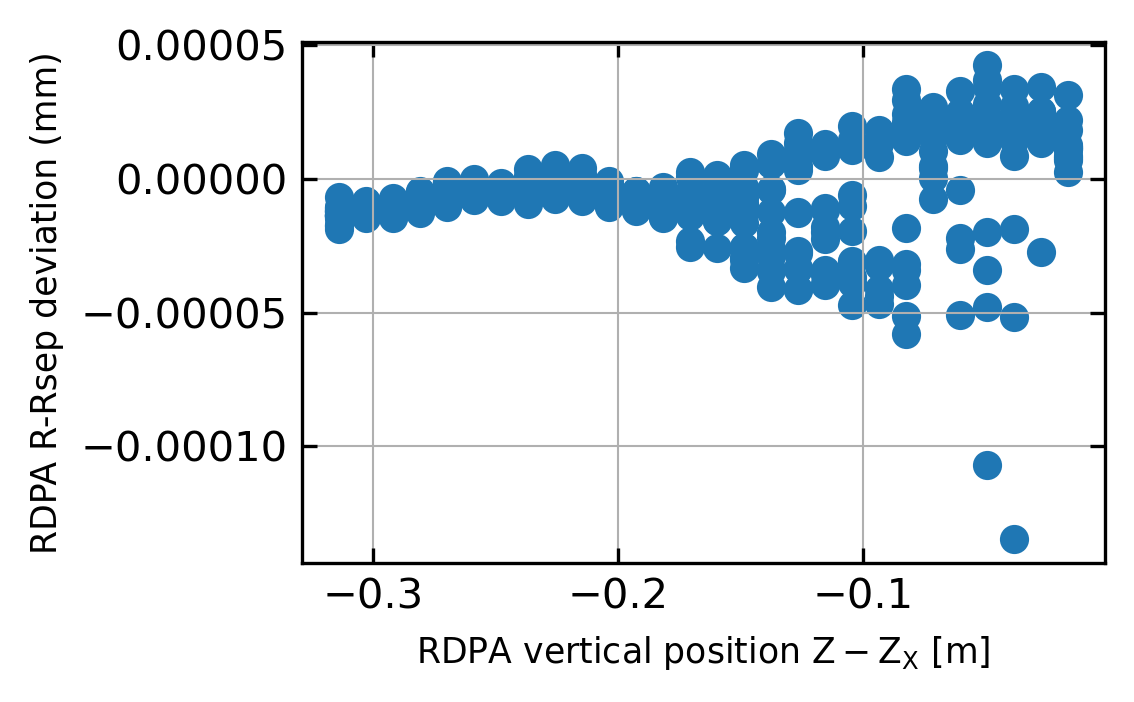

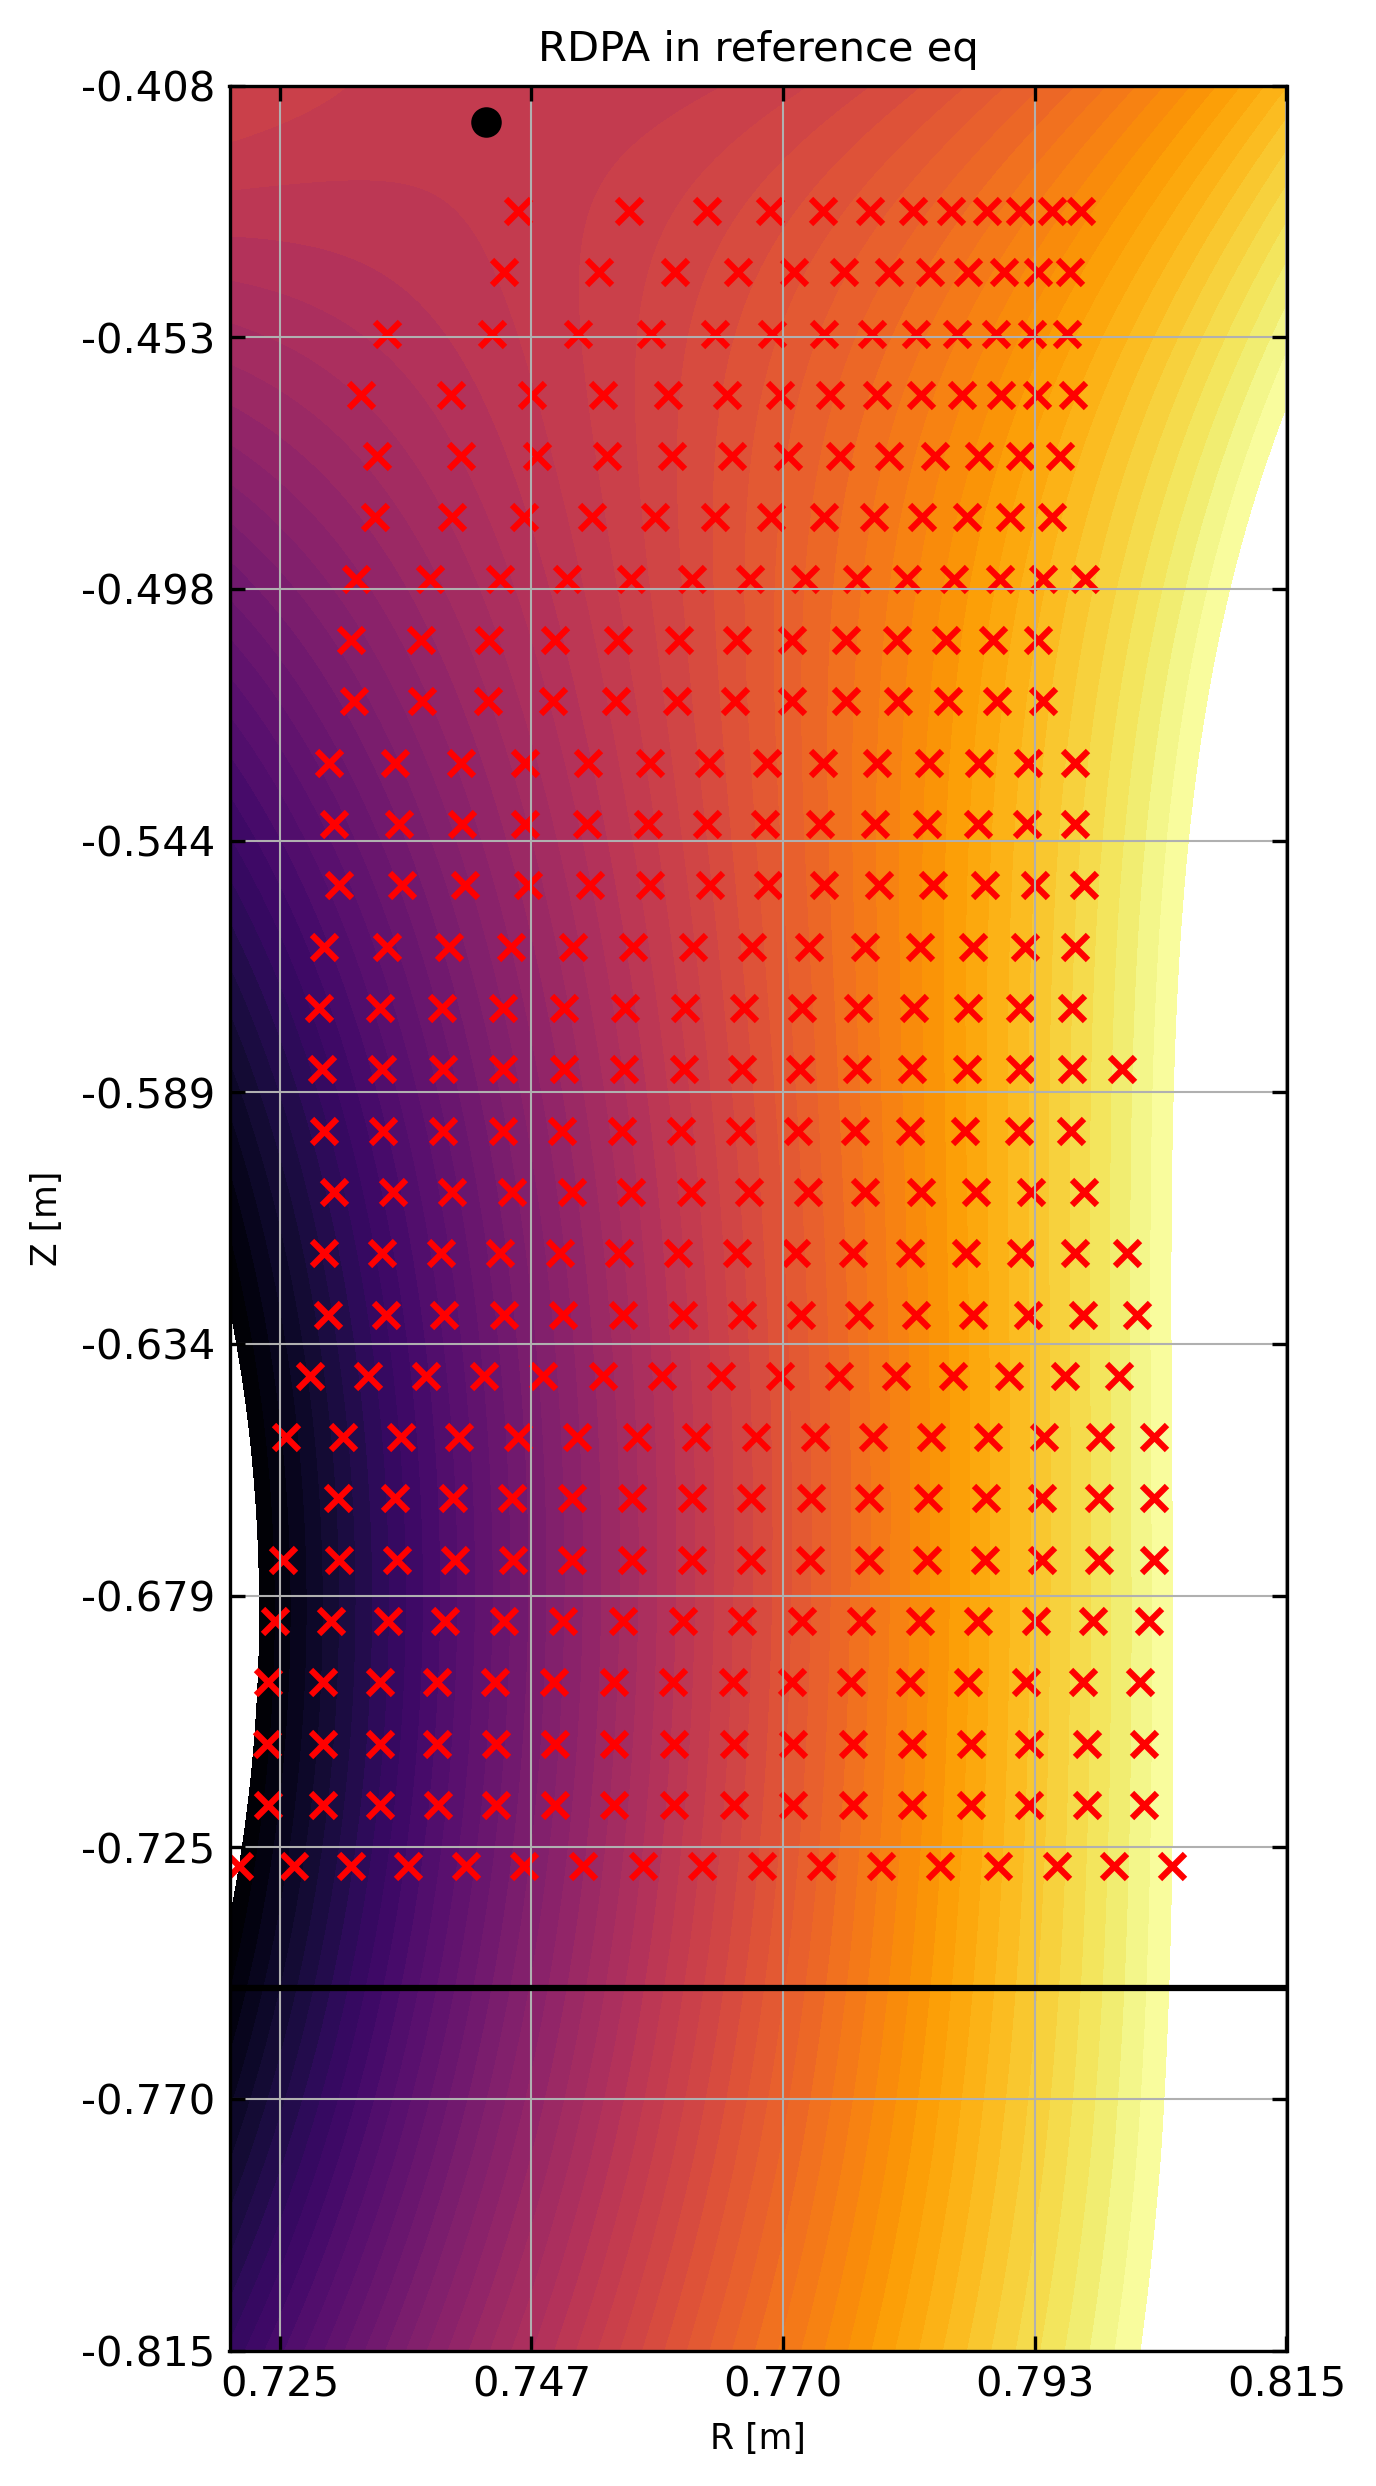

In [6]:
rdpa_r = rdpa_rsep_to_r(rdpa_rsep, rdpa_zx, equi, norm,
                        limits={'rmin': 0.79, 'rmax': 1.0, 'zmin': -0.9, 'zmax': -0.45},
                        r_samples=500, z_samples=1000,
                        precision_required=Quantity(0.1, 'mm'),
                        plot=True)


In [7]:
x_point_z = convert_xarray_to_quantity(equi.x_point_z)
rdpa_z = rdpa_zx + x_point_z

rdpa_dict = {
    'R': rdpa_r.to('m').magnitude,
    'R_units': 'meter',
    'Z': rdpa_z.to('m').magnitude,
    'Z_units': 'meter',
    'Rsep': rdpa_rsep.to('m').magnitude,
    'Rsep_units': 'meter',
    'Zx': rdpa_zx.to('m').magnitude,
    'Zx_units': 'meter',
    'R_axis': equi.axis_r.values,
    'R_axis_units': 'm',
    'Z_axis': equi.axis_z.values,
    'Z_axis_units': 'm',
    'R_x_point': equi.x_point_r.values,
    'R_x_point_units': 'm',
    'Z_x_point': equi.x_point_z.values,
    'Z_x_point_units': 'm',

}

from tcvx21.file_io import write_to_json
write_to_json(rdpa_dict, filepath=Path('RDPA_reference_coords.json'), allow_overwrite=True)
